In [1]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG19, VGG16, DenseNet121
from tensorboard import notebook
from tensorflow import keras 
from tensorflow.keras.applications.resnet import ResNet50
from keras import models, layers
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D, LayerNormalization, Flatten )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

2024-03-16 14:42:41.640563: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def PAB(inputs, channel_size):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    x = tf.reshape(x, [-1, 1, h*w])
    x = Activation('sigmoid')(x)
    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, channel_size]))
    x = tf.reshape(x, [-1, 1, 1, channel_size])
    
    return x

def CAB(inputs, reduction=8):
    shape = K.int_shape(inputs)

    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    
    return x
    
    
def CSDA(inputs,batch_size):

    f1 = []
    f2 = []
    half_size = inputs.shape[-1] // 2

    SPC_out = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=-1))(inputs)
    

    f1 = SPC_out[0]
    f2 = SPC_out[1]

    x = Concatenate()([CAB(f1), PAB(f1, half_size)])
    x = Conv2D(half_size, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    f1 = Multiply()([x, f1])

    y = Concatenate()([CAB(f2), PAB(f2, half_size)])
    y = Conv2D(half_size, 1, padding='same')(y)
    y = Activation('sigmoid')(y)
    f2 = Multiply()([y, f2])

    outputs = Concatenate()([f1, f2])
        
    return outputs
    
    
        

def load_model():
    K.clear_session()
    inputs = Input(shape=(200, 200, 3))
    shape = K.int_shape(inputs)

    net = DenseNet121(weights=None, include_top=False, input_shape=(200, 200, 3))
    x = net.output
    
    x = CSDA(x, 36)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs= net.input, outputs=x)
    
    return model



100%|██████████| 186/186 [00:00<00:00, 193.88it/s]


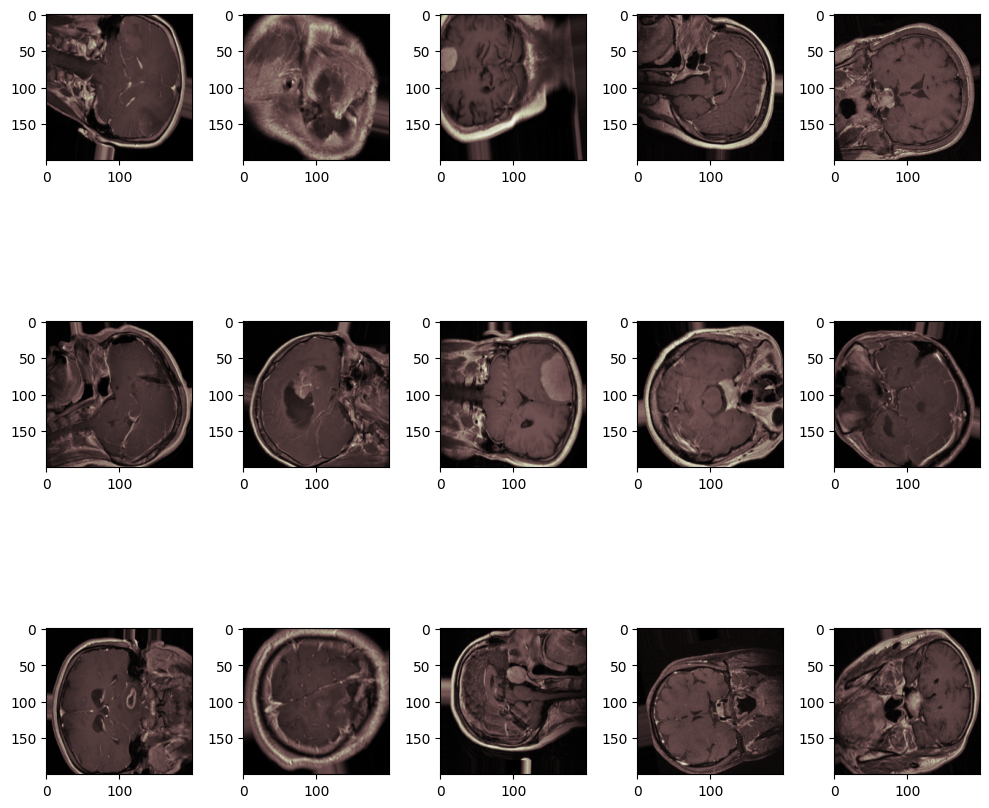

In [130]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [131]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [132]:
tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='CSDACNN.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5901 - accuracy: 0.7474
Epoch 1: saving model to CSDACNN.h5
Epoch 1: 27.34 seconds
264/264 [==============================] - 27s 79ms/step - loss: 0.5900 - accuracy: 0.7475 - val_loss: 2.1300 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8754
Epoch 2: saving model to CSDACNN.h5
Epoch 2: 19.39 seconds
264/264 [==============================] - 19s 73ms/step - loss: 0.3145 - accuracy: 0.8754 - val_loss: 5.3511 - val_accuracy: 0.4004 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9169
Epoch 3: saving model to CSDACNN.h5
Epoch 3: 19.32 seconds
264/264 [==============================] - 19s 73ms/step - loss: 0.2252 - accuracy: 0.9168 - val_loss: 1.4544 - val_accuracy: 0.6281 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - loss: 0.1651 - accura

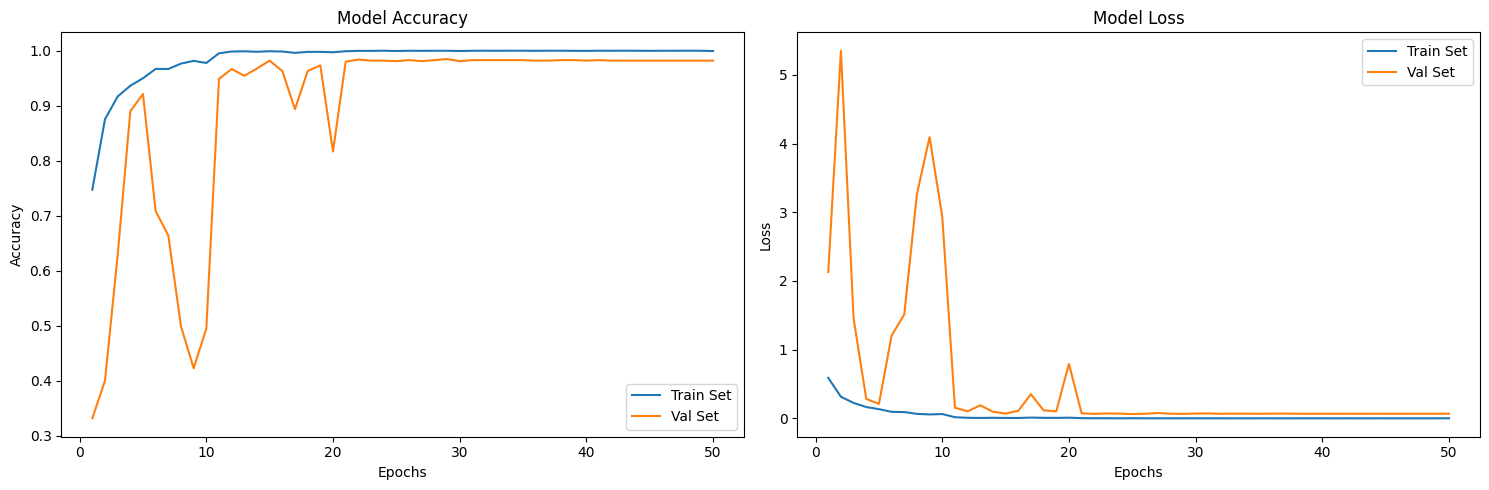

In [133]:
draw_curve(history)

20/20 [==============================] - 0s 18ms/step - loss: 0.1078 - accuracy: 0.9707
Test Accuracy:  97.07
              precision    recall  f1-score   support

      glioma     0.9756    0.9790    0.9773       286
  meningioma     0.9504    0.9437    0.9470       142
   pituitary     0.9785    0.9785    0.9785       186

    accuracy                         0.9707       614
   macro avg     0.9682    0.9671    0.9676       614
weighted avg     0.9706    0.9707    0.9707       614



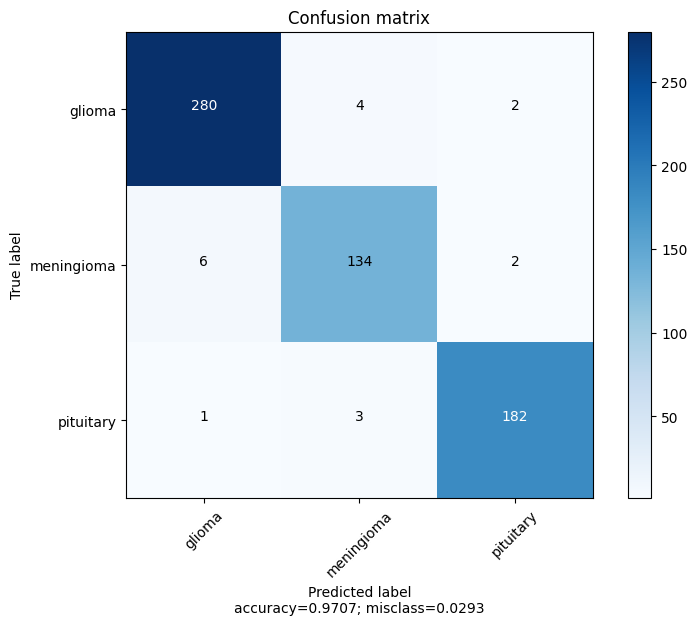

In [134]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [135]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 192.29it/s]


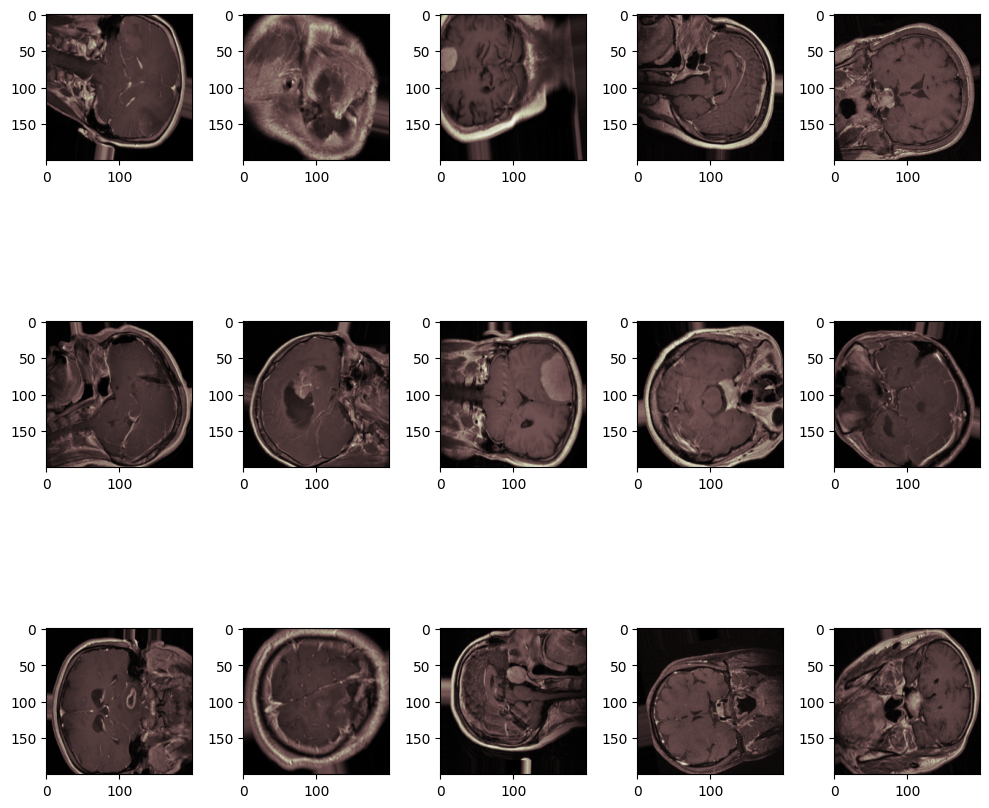

2024-03-16 14:43:48.790583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 14:43:49.086423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


Epoch 1/50


2024-03-16 14:44:03.648140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-16 14:44:04.505479: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-16 14:44:04.505502: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-16 14:44:04.505597: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-16 14:44:05.245375: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.7557
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to CSDACNN2.h5
Epoch 1: 33.40 seconds
264/264 [==============================] - 33s 85ms/step - loss: 0.5767 - accuracy: 0.7557 - val_loss: 3.0441 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8813
Epoch 2: val_accuracy improved from 0.33207 to 0.36053, saving model to CSDACNN2.h5
Epoch 2: 19.96 seconds
264/264 [==============================] - 20s 76ms/step - loss: 0.3082 - accuracy: 0.8813 - val_loss: 6.4181 - val_accuracy: 0.3605 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9167
Epoch 3: val_accuracy improved from 0.36053 to 0.55313, saving model to CSDACNN2.h5
Epoch 3: 19.92 seconds
264/264 [==============================] - 20s 75ms/step - loss: 0.2203 - accuracy: 0.9167 - val_loss: 3.

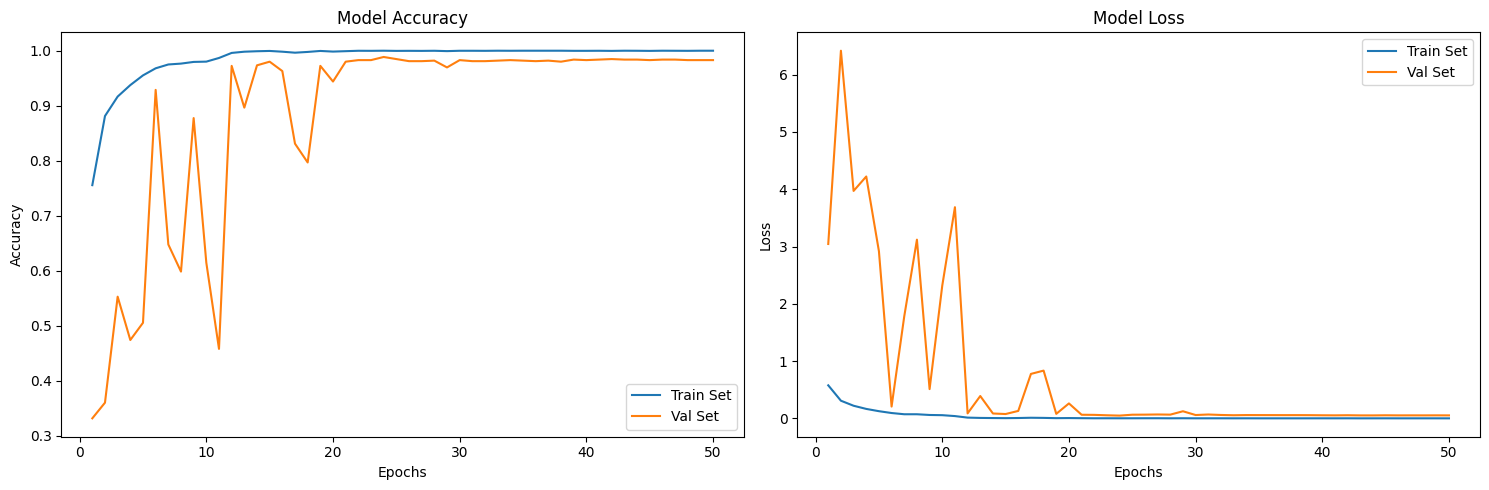

20/20 [==============================] - 0s 16ms/step - loss: 0.1233 - accuracy: 0.9674
Test Accuracy:  96.74
              precision    recall  f1-score   support

      glioma     0.9756    0.9790    0.9773       286
  meningioma     0.9366    0.9366    0.9366       142
   pituitary     0.9784    0.9731    0.9757       186

    accuracy                         0.9674       614
   macro avg     0.9635    0.9629    0.9632       614
weighted avg     0.9674    0.9674    0.9674       614



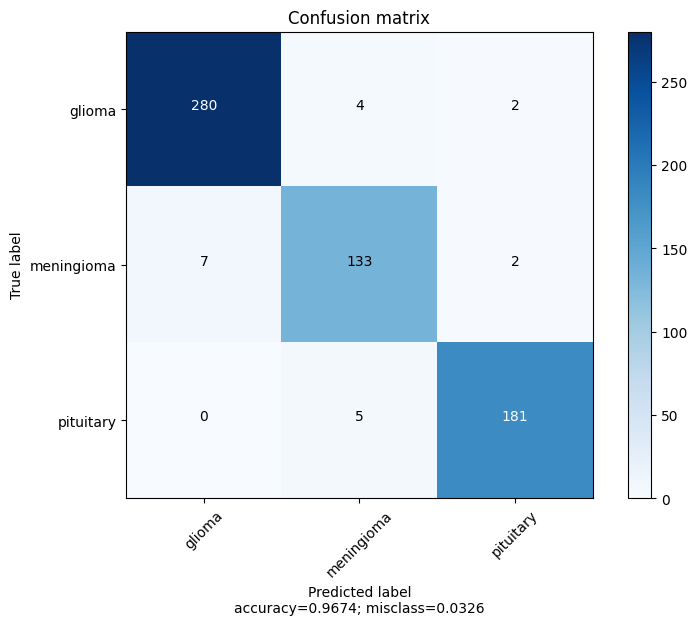

In [3]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CSDACNN2.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 192.64it/s]


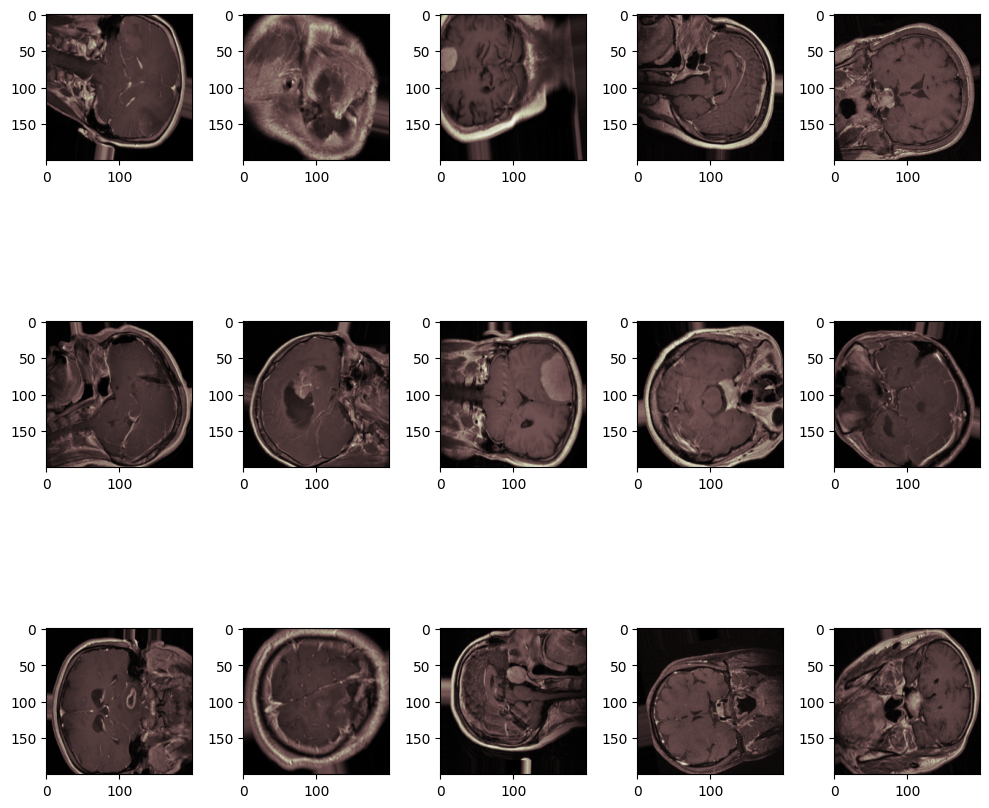

Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.7509
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to CSDACNN3.h5
Epoch 1: 29.07 seconds
264/264 [==============================] - 29s 81ms/step - loss: 0.5893 - accuracy: 0.7509 - val_loss: 3.0306 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8726
Epoch 2: val_accuracy improved from 0.33207 to 0.33871, saving model to CSDACNN3.h5
Epoch 2: 19.98 seconds
264/264 [==============================] - 20s 76ms/step - loss: 0.3257 - accuracy: 0.8726 - val_loss: 4.9119 - val_accuracy: 0.3387 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9165
Epoch 3: val_accuracy improved from 0.33871 to 0.66509, saving model to CSDACNN3.h5
Epoch 3: 19.71 seconds
264/264 [==============================] - 20s 75ms/step - loss: 0.2204 - accuracy: 0.9165 - v

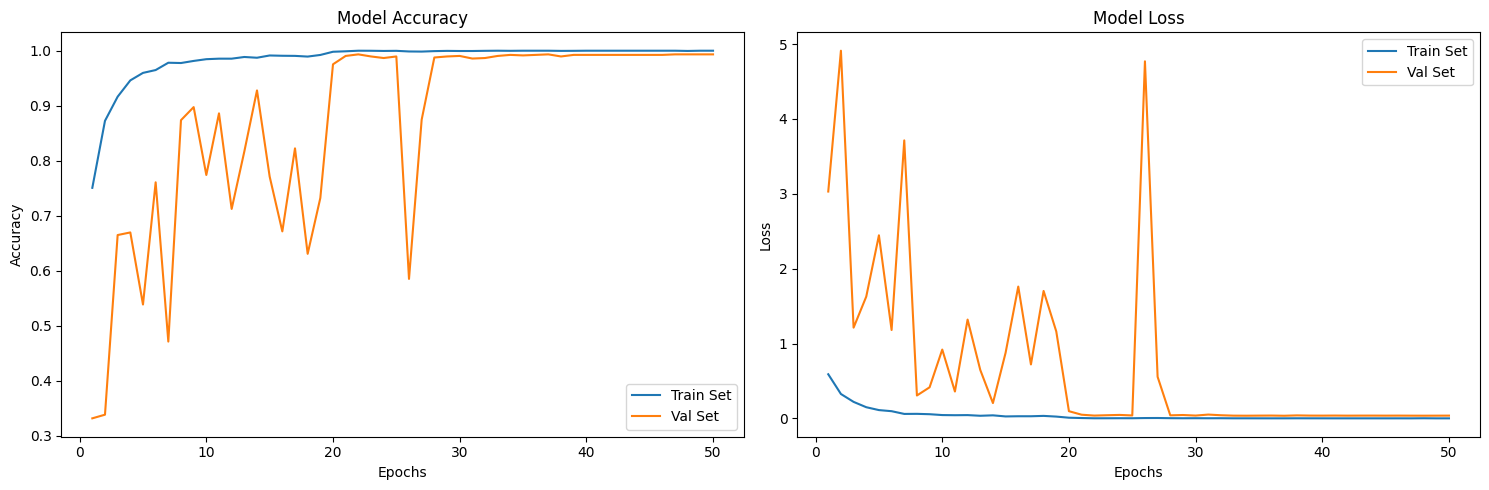

20/20 [==============================] - 0s 19ms/step - loss: 0.0849 - accuracy: 0.9707
Test Accuracy:  97.07
              precision    recall  f1-score   support

      glioma     0.9723    0.9825    0.9774       286
  meningioma     0.9568    0.9366    0.9466       142
   pituitary     0.9785    0.9785    0.9785       186

    accuracy                         0.9707       614
   macro avg     0.9692    0.9659    0.9675       614
weighted avg     0.9706    0.9707    0.9706       614



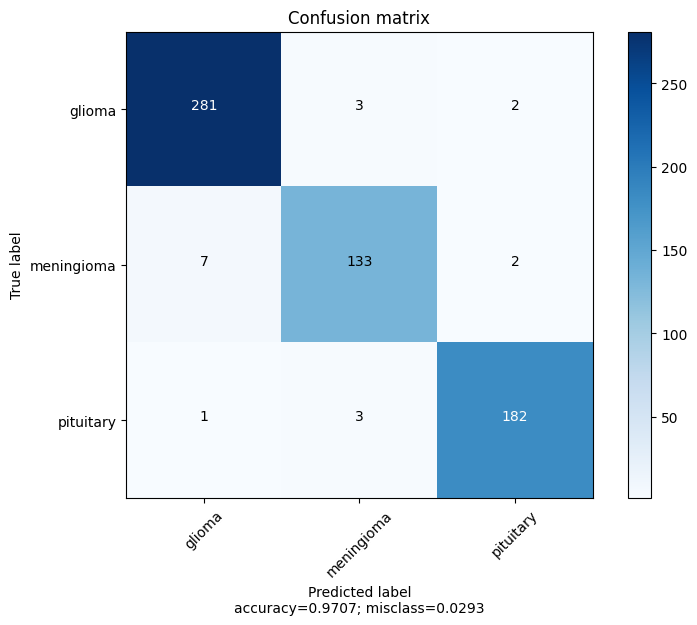

In [4]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CSDACNN3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 192.20it/s]


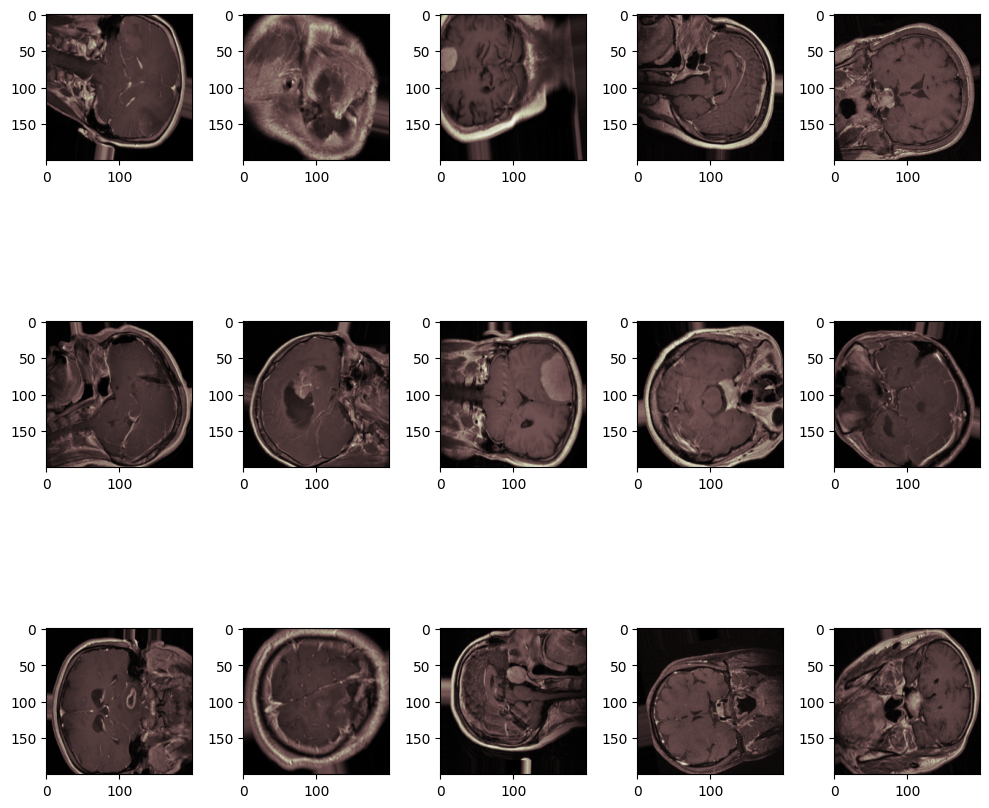

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.5634 - accuracy: 0.7650
Epoch 1: val_accuracy improved from -inf to 0.33397, saving model to CSDACNN4.h5
Epoch 1: 27.43 seconds
264/264 [==============================] - 27s 79ms/step - loss: 0.5632 - accuracy: 0.7650 - val_loss: 5.1207 - val_accuracy: 0.3340 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.8842
Epoch 2: val_accuracy improved from 0.33397 to 0.40987, saving model to CSDACNN4.h5
Epoch 2: 20.03 seconds
264/264 [==============================] - 20s 76ms/step - loss: 0.3029 - accuracy: 0.8842 - val_loss: 4.5493 - val_accuracy: 0.4099 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9174
Epoch 3: val_accuracy improved from 0.40987 to 0.61385, saving model to CSDACNN4.h5
Epoch 3: 19.70 seconds
264/264 [==============================] - 20s 75ms/step - loss: 0.2185 - accuracy: 0.9173 - v

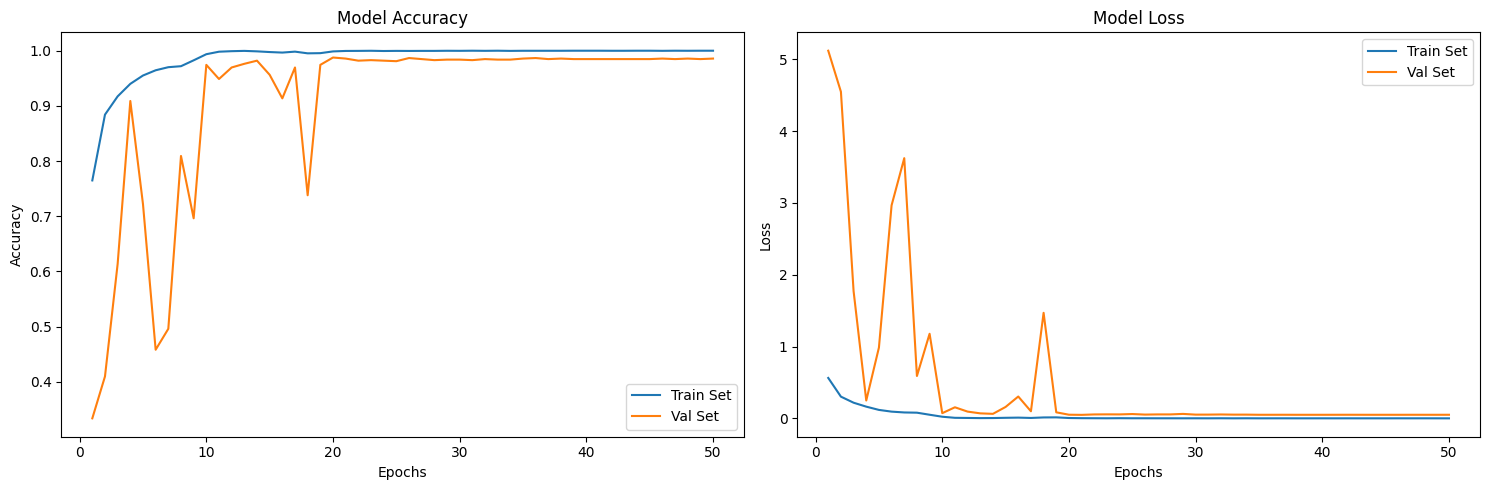

20/20 [==============================] - 0s 20ms/step - loss: 0.1165 - accuracy: 0.9658
Test Accuracy:  96.58
              precision    recall  f1-score   support

      glioma     0.9656    0.9825    0.9740       286
  meningioma     0.9429    0.9296    0.9362       142
   pituitary     0.9836    0.9677    0.9756       186

    accuracy                         0.9658       614
   macro avg     0.9640    0.9599    0.9619       614
weighted avg     0.9658    0.9658    0.9657       614



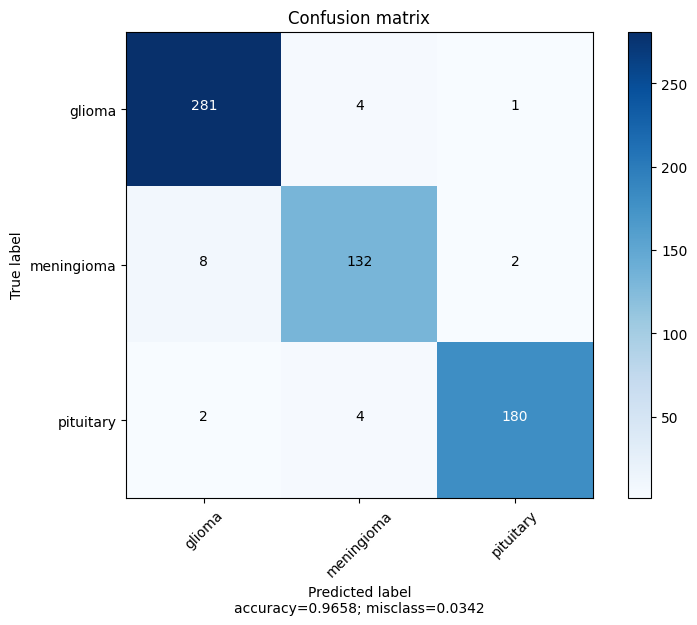

In [5]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CSDACNN4.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 192.46it/s]


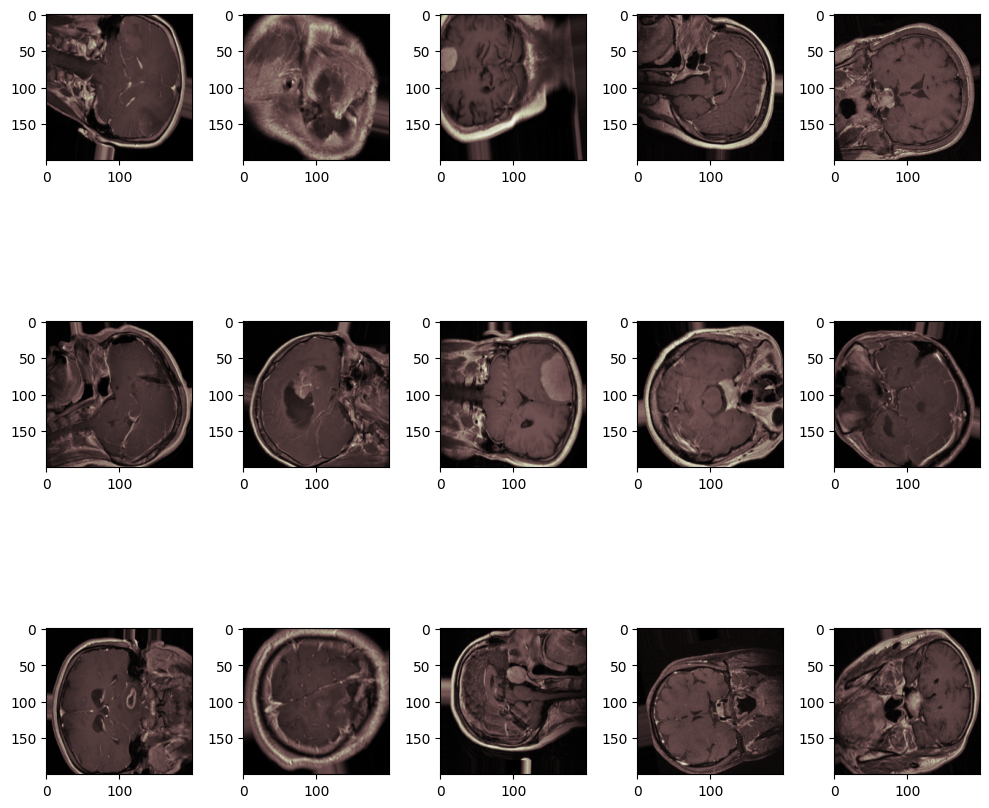

Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.7566
Epoch 1: val_accuracy improved from -inf to 0.33207, saving model to CSDACNN5.h5
Epoch 1: 28.19 seconds
264/264 [==============================] - 28s 82ms/step - loss: 0.5859 - accuracy: 0.7566 - val_loss: 4.8218 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.8793
Epoch 2: val_accuracy improved from 0.33207 to 0.44307, saving model to CSDACNN5.h5
Epoch 2: 19.82 seconds
264/264 [==============================] - 20s 75ms/step - loss: 0.3118 - accuracy: 0.8793 - val_loss: 5.3252 - val_accuracy: 0.4431 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9167
Epoch 3: val_accuracy improved from 0.44307 to 0.76376, saving model to CSDACNN5.h5
Epoch 3: 19.87 seconds
264/264 [==============================] - 20s 75ms/step - loss: 0.2230 - accuracy: 0.9165 - v

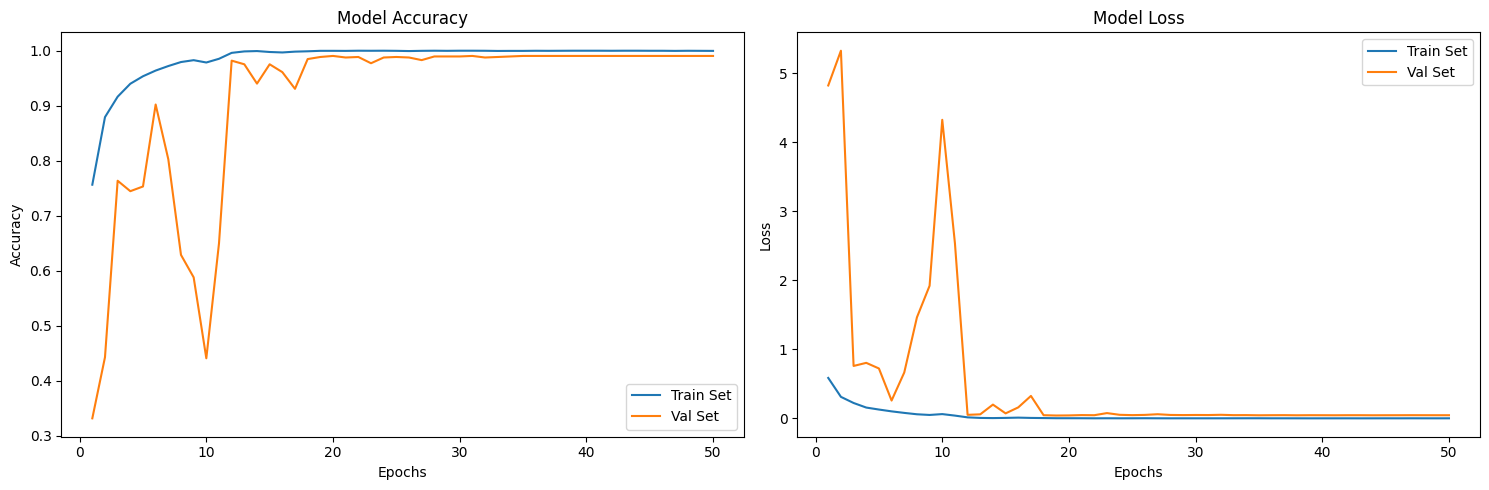

20/20 [==============================] - 0s 19ms/step - loss: 0.1036 - accuracy: 0.9707
Test Accuracy:  97.07
              precision    recall  f1-score   support

      glioma     0.9825    0.9790    0.9807       286
  meningioma     0.9375    0.9507    0.9441       142
   pituitary     0.9784    0.9731    0.9757       186

    accuracy                         0.9707       614
   macro avg     0.9661    0.9676    0.9668       614
weighted avg     0.9708    0.9707    0.9707       614



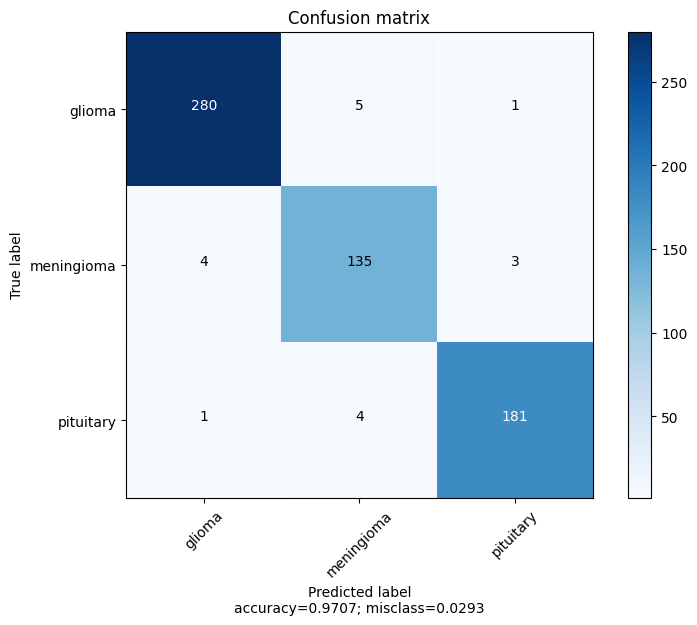

In [6]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CSDACNN5.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f